In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression



import itertools
from itertools import cycle

%load_ext autoreload
%autoreload 2

import helpers.helper as helpers


mpl.rc('figure', max_open_warning = 0)

%matplotlib inline

# Graded Exercise 1

**Date: 30.10.2020**

Welcome to the first graded exercise. In this exercise, you will be tested on the following topics: linear regression, linear classification, linear SVM, kNNs and different evaluation metrics.

You are asked to fill in the code in a couple of cells throughout the exercise.

Good luck! :-)

# Part 1: SVM

### 1.1 Margin Width
SVM tries to maximize the margin between classes. When accounting for potential class overlap, this maximization comes at the cost of allowing the misclassification of some of the data points. In the following exercise, we ask you to find the width (or magnitude) of the margin of a linear SVM for given regularization hyper-parameter C. You can use scikit-learn's SVM functions.

Hint: You can access the dual coefficients and support vectors after fitting from the SVC object. Check the attributes in this documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html . Lecture 4 slide 22 shows how to compute distance of a point to the decision boundary.

The weight estimates matrix can be computed as the the dot product between dual coefficients and support vector inputs:
$$
    \tilde{\mathrm{w}}^* = \sum_{i\in SV} \alpha_i^*y_i x_i
$$
The width of the margin equals twice the computed margin in the SVM model. The model margin equals $$ r=\frac{\tilde{y}(x)}{\Vert\mathrm{w}\Vert}$$

In [3]:
def find_margin_width(X,y,C):
    '''
        X: input data NxD
        y: output label N
        C: scalar value for the regularization term 
        
        return: a scalar width
    '''
    # Initialize the SVM model with linear kernel
    clf = SVC(kernel='linear', C=C)
    clf.fit(X, y) # model fitting

    # Compute weight estimates matrix 
    #   (dual_coeff are zero for non-support vectors)
    weights = np.sum(clf.dual_coef_.T * clf.support_vectors_, axis=0)

    # Width equals twice the margin - y estimates have 
    #   absolute value 1 for x on margin - r = y / norm(w)
    width = 2/np.linalg.norm(weights)
    return width

# Part 2. Classification Metrics
$\renewcommand{\real}{\mathbb{R}}$

In this exercise we will look at some standard means of assessing the quality of binary classifiers, namely the *ROC curve*.

Imagine an apple processing factory which has a very unfortunate location in a war zone. There is a conveyor belt bringing harvested apples inside the factory. However, every now and then, a grenade falls on the conveyor belt. To prevent a disaster in the factory, we deploy an automatic apple/grenade classification system. However, since we are underfunded, we can only afford to measure either the weight or the volume of every item on the conveyor belt (not both at the same time). Therefore, we need to decide if we employ a classifier that takes the weight as input, or one that takes the volume.

We are given a training dataset containing $N$ samples of apples and grenades with their weight and volume measurements. Furthermore, we decide that our final classifier will be a simple threshold on either the weight or the volume of each incoming item. That is 

$$P(x_i == grenade) = \begin{cases} 
      1 & f(x_i) > t \\
      0 & \text{otherwise} \\
   \end{cases},
$$

where $f(x_i)$ measures either the weight or the volume of the item $x_i$ and $t \in \real$ is a selected threshold. The implementation of this classifier which you will be using is provided in the cell below.

In [4]:
def class_thresh(X, t):
    """ Classifies 1D data X given a threshold `t`.
    
    Args:
        X (np.array): Data, shape (N, )
        t (float): Threshold.
        
    Returns:
        np.array: Predicted labels, shape (N, ).
    """
    assert X.ndim == 1
    return (X >= t).astype(np.int32)

Now, let us have a look at our dataset. By projecting the data either to the *weight* or *volume* axis, we can immediatelly see that it is not clear at all whether weight or volume is a better indicator of receiving a grenade.

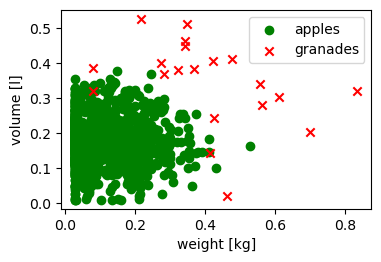

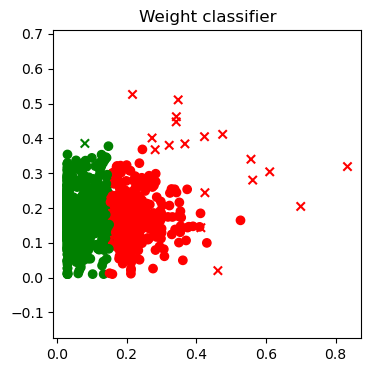

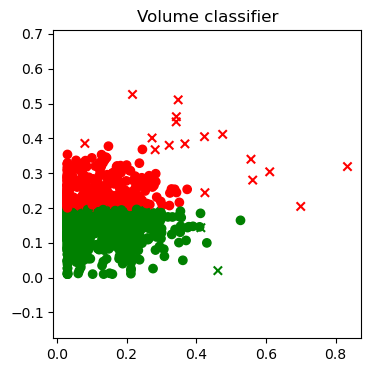

In [6]:
X, y = helpers.generate_apple_grenade_data()
helpers.plot_apple_grenade_data(X, y, class_thresh)

Your task will be to implement the simple threshold classifier and then evaluate it both for weight and volume features individually to decide, which one can detect granades more reliably. To this end, we will use a technique common for evaluating binary classifiers, the *ROC curve*.

Let the threshold $t$ vary from the minimum to the maximum value (of either weight or volume) in the whole dataset. Generate the ROC  curve. You can use the helper function *plot_roc_curves*, please study their interface.

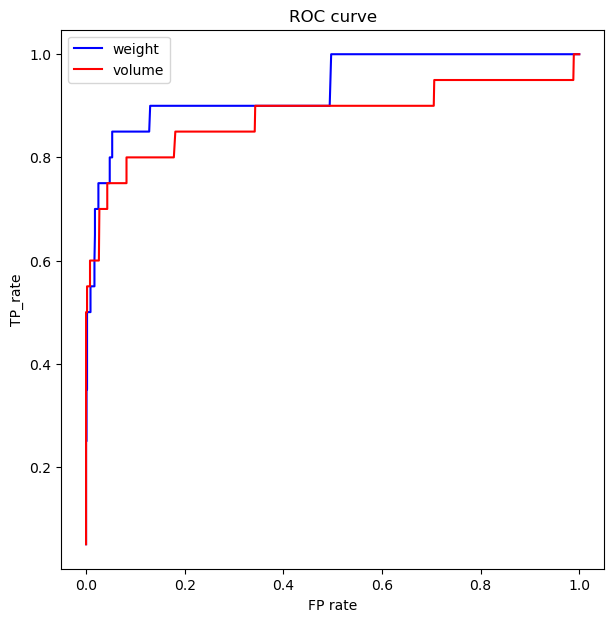

In [8]:
def true_false_pos_neg(y_gt, y_p):
    """ Computes TP, FP, TN, FN.
    
    Args:
        y_gt (np.array): GT labels, shape (N, ).
        y_p (np.array): Pred. labels, shape (N, ).
        
    Returns:
        floats: TP, FP, TN, FN
    """
    assert y_gt.ndim == 1 and y_p.ndim == 1
    assert y_gt.shape[0] == y_p.shape[0]
    N = y_gt.shape[0]
    
    # Compute True Positives
    tp = np.sum((y_gt == 1) * (y_p == 1))
    # Compute False Positives
    fp = np.sum((y_gt == 0) * (y_p == 1))
    # Compute True Negatives
    tn = np.sum((y_gt == 0) * (y_p == 0))
    # Compute False Negatives
    fn = np.sum((y_gt == 1) * (y_p == 0))

    
    assert tp + fp + tn + fn == N
    return tp, fp, tn, fn

def tp_rate(tp, fp, tn, fn):
    """ Returns true positive rate - recall (out of all positives).
    Note: You may not need to use all the arguments
    
    Args:
        fp (float): number of false positives
        tp (float): number of true positives
        tn (float): number of true negatives
        fn (float): number of false negatives
        
        
    Returns:
        tp_rate (float): TP rate.
    """
    rec = tp / (tp + fn)
    return rec

def fp_rate(tp, fp, tn, fn):
    """ Returns false positive rate (out of all negatives).
    Note: You may not need to use all the arguments
    
    Args:
        fp (float): number of false positives
        tp (float): number of true positives
        tn (float): number of true negatives
        fn (float): number of false negatives
        
        
    Returns:
        fp_rate (float): FP rate.
    """
    return fp / (fp + tn)

def roc_curve(fcl, x, y, ts):
    """ Computes data for ROC curve.
    
    Args:
        fcl (callable): Classification function.
        x (np.array): Data, shape (N, ).
        y (np.array): Gt labels, shape (N, ).
        ts (np.array): Thresholds, shape (T, ).
        
    Returns:
        tp_rates (np.array): TP rates, shape (T, ).
        fp_rates (np.array): FP rates, shape (T, ).
    """
    tp_rates = []
    fp_rates = []
    for thres in ts:
        y_pred = fcl(x, thres)
        tp, fp, tn, fn = true_false_pos_neg(y, y_pred)
        tp_rates.append(tp_rate(tp, fp, tn, fn))
        fp_rates.append(fp_rate(tp, fp, tn, fn))
    return np.array(tp_rates), np.array(fp_rates)

steps = 1000

### ROC curve
ts1 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), steps)
ts2 = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), steps)

helpers.plot_roc_curves(
    *roc_curve(class_thresh, X[:, 0], y, ts1)[::-1], 
    *roc_curve(class_thresh, X[:, 1], y, ts2)[::-1])


Looking at the curve, decide which classifier is better and write its name in the variable *final_classifier* below. `Answer`: The better **classifier** considers the $\texttt{weight}$ measurements between grenades and apples.

In [ ]:
final_classifier = 'weight' # 'weight' or 'volume'

# Part 3: Multiclass Logistic Regression
$\renewcommand{\real}{\mathbb{R}}$
$\newcommand{\nonnegint}{\mathbb{N_{0}}}$
$\newcommand{\xb}{\mathbf{x}}$
$\newcommand{\wb}{\mathbf{w}}$
$\newcommand{\Xb}{\mathbf{X}}$
$\newcommand{\yb}{\mathbf{y}}$
$\newcommand{\Yb}{\mathbf{Y}}$

In exercise session 4 you implemented binary logistic regression. In this exercise we will extend the idea to a logistic regression classifier operating on multiple classes.

Let us consider logistic regression for $C$ classes. The weights are stored in a weight matrix $\mathbf{W}$, where every column is $\wb_{(k)}$ for class $k$. Therefore, for every class $k$, we learn a separate $\wb_{(k)}$ during training. The weight matrix will be of size $((D + 1) \times C)$, where $D$ is dimension of the input ($2$ in our case).

First, let us have a look at the data we are dealing with. We have $N$ samples in $3$ classes. Let $X \in \real^{N \times (D + 1)}$ be the training input matrix, $Y \in \nonnegint^{N \times C}$ be ground-truth labels, and $W \in \real^{D \times C}$ be the weight matrix. Run the cell below to load and plot the data. Each class is denoted by a different marker and color.

As you can see, the classes severly overlap, and thus we cannot expect $100 \%$ accuracy for our trained model, since there is clearly no set of linear decision boundaries which perfectly separates the data.

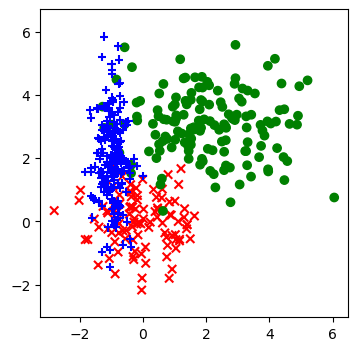

In [2]:
### Generate data.

# Settings.
mus = np.array([[0., 0.], [2., 3], [-1., 2.]])
stds = np.array([[0.75, 0.75], [2.5, 1.0], [0.1, 1.5]])
Ns = np.array([100, 150, 200])
C = Ns.shape[0]

# Data.
X, Y = helpers.generate_data(mus, stds, Ns, labels_one_hot=True,
                     bias=True, shuffle=True)
fig = helpers.vis_classes_prediction(X, Y, Y, Ns.shape[0])

We will start with implementing the basic building blocks of the multi-class logistic regression that you saw in class, namely

- the softmax function
- the loss function
- the gradient computation
- the class prediction function.

We prepared the declaration of the corresponding functions below, please implement the bodies of the functions.

The generalized probabilities for logistic regression computed as $\texttt{softmax}$ function is
$$\hat{y}^{(k)}(\xb_i) = P(y_i=k|\xb_i, \mathbf{W}) = \frac{e^{\xb_i^\top\cdot \wb_{(k)}}}{\sum_j^C e^{\xb_i^\top\cdot \wb_{(j)}}}$$
Loss function:
$$R(\mathbf{W}) = -\sum_{i}^N\sum_{k}^Cy_i^{(k)}\log(\hat{y}^{(k)}(\xb_i)) \\
=-\sum_{i}^N\sum_{k}^Cy_i^{(k)}\log(f_\text{softmax}(\xb_{i}^\top \cdot \wb_{(k)}))$$ 
Gradient of loss function:
$$\nabla R(\mathbf{W})= \Xb^T(\hat{\yb}(\Xb) - \Yb)$$

In [4]:
### Logistic regression.

def softmax(X, W):
    """ Computes softmax.
    
    Args:
        X (np.array): Data, shape (N, D), 
            N is # samples, D is dimension.
        W (np.array): Weights, shape (D, C), 
            C is # classes.
            
    Returns:
        np.array: Result of shape (N, C).
    """
    
    return np.exp(X @ W) / np.sum(np.exp(X @ W), axis=1, keepdims=True)

def loss_logreg(X, Y, W):
    """ Loss function for multi class logistic regression.
    
    Args:
        X (np.array): Input data, shape (N, D).
        Y (np.array): GT labels as one-hot, shape (N, C).
        W (np.array): Weights, shape (D, C).
        
    Returns:
        float: Loss value.
    """
    loss = - np.sum(Y * np.log(softmax(X, W)))
    return loss

def gradient_logreg(X, Y, W):
    """ Gradient function for multi class logistic regression.
    
    Args:
        X (np.array): Input data of shape (N, D).
        Y (np.array): GT labels as one-hot, shape  (N, C).
        W (np.array): Weights, shape (D, C).
        
    Returns:
        np.array: Gradients, shape (D, C).
    """
    grad = X.T @ (softmax(X, W) - Y)
    return grad

def predict_logreg(X, W):
    """ Prediction of a class label (index) per data sample.
    
    Args:
        X (np.array): Input data of shape (N, D).
        W (np.array): Weights, shape (D, C).
        
    Returns:
        np.array: Predicted labels as indices, (N, ).
    """
    y_hat = softmax(X, W)
    preds = np.argmax(y_hat, axis=1) 
    return preds

Finally, let us train the logistic regression on the given training dataset. We have provided the training code for you. 

Upon successful training, you should see an accuracy of $\sim88 \%$.

Iter 10 - loss: 207.48, acc: 0.82
Iter 20 - loss: 179.86, acc: 0.84
Iter 30 - loss: 165.59, acc: 0.86
Iter 40 - loss: 157.10, acc: 0.87
Iter 50 - loss: 151.60, acc: 0.88
Iter 60 - loss: 147.82, acc: 0.88
Iter 70 - loss: 145.10, acc: 0.89
Iter 80 - loss: 143.07, acc: 0.88
Iter 90 - loss: 141.51, acc: 0.88
Iter 100 - loss: 140.29, acc: 0.88


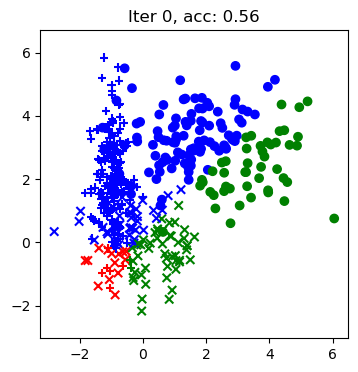

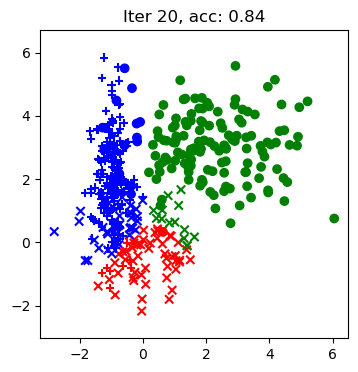

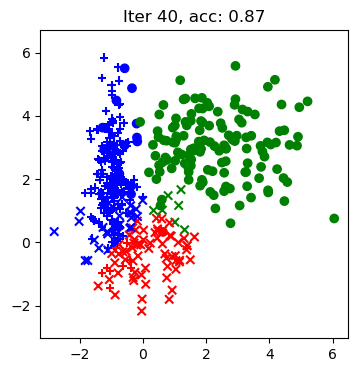

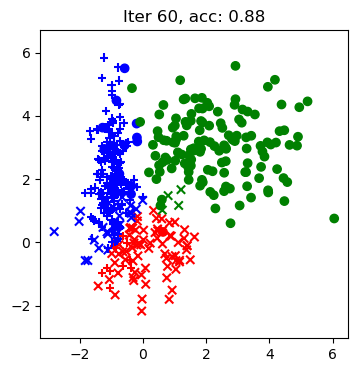

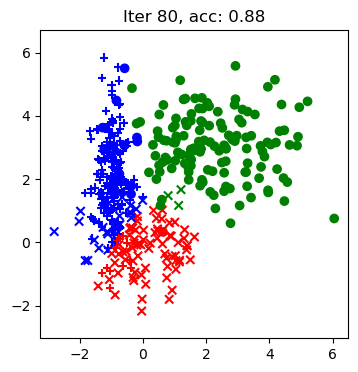

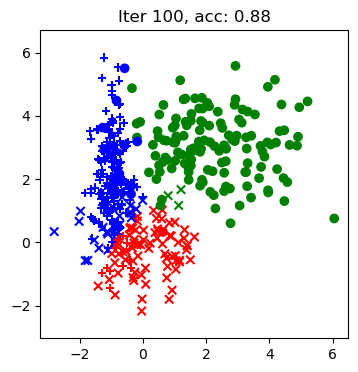

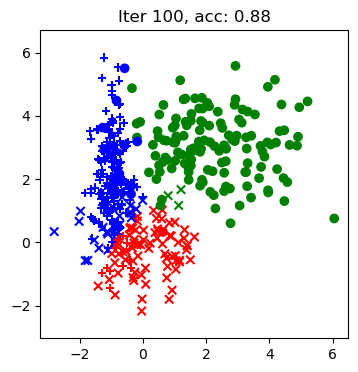

In [7]:
def train_logreg(X, Y, C, max_iters, lr, print_period=10, plot_period=20):
    """ Training function for multi class logistic regression. 
    
    Args:
        X (np.array): Dataset of shape (N, D).
        Y (np.array): Labels of shape (N, C).
        C (int): Number of classes.
        max_iters (integer): Maximum number of iterations.
        lr (float): The learning rate of  the gradient step.
        print_period (int): Printing period.
        plot_period (int): Plotting period.

    Returns:
        np.array: Learned weights, shape (D, C).
    """
    figs = []
    Yinds = helpers.onehot_to_label(Y)

    # Initialize weights.
    W = np.random.normal(0, 0.1, (X.shape[1], C))  
    
    # Initial prediction.
    acc = helpers.my_accuracy_func(Yinds, predict_logreg(X, W))
    figs.append(helpers.vis_classes_prediction(
        X, Y, predict_logreg(X, W), C, title=f"Iter 0, acc: {acc:.2f}"))
    
    # Train.    
    for it in range(max_iters):

        # Compute the gradient and update the weights.
        gW = gradient_logreg(X, Y, W)
        W -= lr * gW
                
        if print_period and (it + 1) % print_period == 0:
            acc = helpers.my_accuracy_func(Yinds, predict_logreg(X, W))
            loss = loss_logreg(X, Y, W)
            print(f"Iter {it + 1} - loss: {loss:.2f}, acc: {acc:.2f}")
        if plot_period and (it + 1) % plot_period == 0:
            acc = helpers.my_accuracy_func(Yinds, predict_logreg(X, W))
            figs.append(helpers.vis_classes_prediction(
                X, Y, predict_logreg(X, W), C, 
                title=f"Iter {it + 1}, acc: {acc:.2f}"))

    acc = helpers.my_accuracy_func(Yinds, predict_logreg(X, W))
    figs.append(helpers.vis_classes_prediction(
        X, Y, predict_logreg(X, W), C, 
        title=f"Iter {it + 1}, acc: {acc:.2f}"))

    plt.show()
    for f in figs:
        plt.close(f)
    
    return W


# Set max iters. and the learning rate.
max_iters = 100
lr = 0.001

W_star = train_logreg(X, Y, C, max_iters, lr)

# Part 4: Polymonial Feature Expansion and Linear Regression

## 4.1. Feature expansion with pairwise products

Recall that in the earlier linear regression exercise, we practiced to expand the features by a degree of 2. Here, we will explore this direction further to see if there is a better option.

Specifically, you will implement a new version of the expansion function that (i) goes beyond degree 2 by computing the $m^th$ power of the individual variables up to degree M; and (ii) considers not only each variable individually but also the products of each pair of variables (i.e., $x_i^{(j)}x_i^{(k)}$). You will then compare the performance of this expansion with the one obtained in the original exercise. 

Hint: the functions from the previous exercise are located in `helpers/expansion.py`.

In [8]:
from helpers.expansion import *
X_train, y_train, X_test, y_test = helpers.load_boston_dataset()

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/home/zedrichu/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

In [10]:
def expand_X_with_pairwise_products(X, M):
    """
    Perform a degree-M polynomial feature expansion of X by computing the $m^th$ power of each individual variable, for m ranging from 1 to M, and by additionally computing the products of any 2 variables.
    Solve this with only numpy functions. You may not use sklearn here.

    Hint: 
        - Although the degree is M, for the pairwise terms, only compute the products of 2 original variables (i.e., $x_i^{(j)}x_i{(k)}$), without any higher degree terms.
        - You may use outter products to avoid using a big for loop
        - Concatenate the pairwise products at the end of the vector containing all the $m^th$ powers of individual variables
    """
    
    """
    Please fill in the required code here
    """

    expand_without_pairwise_products = np.ones((X.shape[0],1))
    for idx in range(1,M+1): expand_without_pairwise_products=np.hstack((expand_without_pairwise_products, X**idx))

        
    # create the interactions between two variable
    # X is (N, d), we first make it as (N, d, 1) and (N, 1, d), then compute the interaction
    X_inter1 = np.expand_dims(X, axis=1) # Intermediate shape (N, d, 1)
    X_inter2 = np.expand_dims(X, axis=2) # Intermediate shape (N, 1, d)
    full_inter = np.matmul(X_inter2, X_inter1) # Cross-multiply the 2 intermediates
    indices = np.triu_indices(full_inter.shape[1], k=1) # Upper-triangle indices
    # Select interactions from cross-multiplication
    interactions = np.zeros((X.shape[0], len(indices[0])))
    for n in range(X.shape[0]):
        interactions[n] = full_inter[n][indices]
    # Concatenate the 2 obtained feature expansions
    return np.concatenate((expand_without_pairwise_products, interactions), axis=1)

You will now implement a function to first expand the features X and then normalize them. Remember in the previous exercise what to do with the bias term when normalizing. We provide the `normalize` function below.

In [11]:
def normalize(X, means=None, stds=None):
    
    """
    Perform normalization by 
    subtracting the means and stds of the features 
    from X.
    
    If the mean and std has been provided externally (not None),
    then use those. Otherwise, compute your own mean and std

    """
    if means is None:
        mu    = np.mean(X,0,keepdims=True)
    else:
        mu = means
        
    if stds is None:
        std   = np.std(X,0,keepdims=True) 
    else:
        std = stds
    
    #subtract means, divide by std
    X = (X-mu)/std
    
    return X, mu, std

Note that, compared to the earlier exercise, there is one additional argument `expand_fn`. The reason to have this additional argument is to avoid duplicating the same function. This argument will then take the value either `expand_X` or `expand_X_with_pairwise_products`, that is, the name of the function to call.

Hint:
- When `expand_fn=expand_X`, it will be identical to the earlier exercise.


In [12]:
def expand_and_normalize_X(X,d, expand_fn):
    """
    Perform degree-d polynomial feature expansion of X.
    
    It should support both expand_X and expand_X_with_pairwise_products,
    use expand_fn to pass the correct method.
    """
    
    if expand_fn is None:
        print('Warning, please call the correct expand_fn')
        return None 

    expand = expand_fn(X, d)
    expand_noBias, mu, std = normalize(expand[:, 1:])
    expand[:, 1:] = expand_noBias
    return expand, mu, std


## 4.2. Cross-validation on degree

Now let's compare the performance of these two expansion functions, `expand_X` from the earlier exercise and `expand_X_with_pairwise_products` implemented here. 

Please return the best validation score and degree in the `grid_val` dictionary.
Specifically, you will need to construct a dictionary with this format:
```
grid_val[function_name] = (best_valid_loss, best_degree)
# where function_name is either ['expand_X', 'expand_X_with_interaction']
```


Hint: 
- Please refer to the earlier exercise session
- We provide the `grid_search_cv` under `helpers/expansion.py` with two additional argument: `expand_fn` and `expand_and_normalize_X`. You can pass the original `expand_X` and the implemented one `expand_X_with_pairwise_products` to perform k-fold grid search directly.
Example usage:
```
result = grid_search_cv(params,k_fold,fold_ind, expand_fn, expand_and_normalize_X,X_train,y_train)
```



In [14]:
from helpers.expansion import fold_indices, grid_search_cv, do_cross_validation

# form the k-fold indices
k_fold=3
num_train_examples = X_train.shape[0]
fold_ind = fold_indices(num_train_examples,k_fold)

# stores the expansion functions
expansion_function_dictionary = {"expand_X": expand_X, "expand_X_with_pairwise_products": expand_X_with_pairwise_products} 

# The grid search parameters are the search degrees:
search_degree = np.arange(1,15)
params={'degree':search_degree}

grid_val = {}

for expansion_function_name, expansion_function in expansion_function_dictionary.items():
    print('Result for expand function :{}'.format(expansion_function_name))
    
    """
    Fill your code here
    """
    #call to the grid search function
    _grid_val, _grid_val_std = grid_search_cv(params, k_fold, fold_ind, expansion_function, 
        expand_and_normalize_X, X_train, y_train)

    """
    End of your code
    """
    #get the best validation score
    best_score = np.min(_grid_val)
    print('Best val score {}'.format(best_score))

    #get degree which gives best score
    best_degree = search_degree[np.argmin(_grid_val)]
    print('Best val score for degree {}'.format(best_degree))

    # add to the dictionary 
    grid_val[expansion_function_name] = (best_score, best_degree)


print(grid_val)

Load the fold indices successfully!
Result for expand function :expand_X
Evaluating for {'degree': 1} ...
The training loss is 11.122196098678275 with std:19.405442765319208. The val loss is 12.664067872227625 with std:22.771155115598496.
The training loss is 10.983048969721127 with std:19.760589539553916. The val loss is 13.044907643611056 with std:20.777981668845495.
The training loss is 11.966907881467323 with std:19.7417123676068. The val loss is 11.427198310175491 with std:20.465426381473705.
Evaluating for {'degree': 2} ...
The training loss is 8.392076855229305 with std:18.213580013402872. The val loss is 9.226573241445902 with std:15.155442461522433.
The training loss is 6.837551758950914 with std:12.98921737314295. The val loss is 16.69570752427813 with std:70.1948127383242.
The training loss is 8.726950925714332 with std:19.8318767848639. The val loss is 10.645608444875558 with std:21.692530600265258.
Evaluating for {'degree': 3} ...
The training loss is 6.6823985961287296 wi

# Part 5: kNN

In this exercise we will ask you to implement a **$k$-Nearest Neighbor classifier (kNN)** and compare the impact of different distance metrics on the final accuracy. 

## 5.1. Data loading

As usual, we provide some data for this exercise.  

In [15]:
data_train, data_test, labels_train, labels_test, class_names = helpers.load_knn_data()

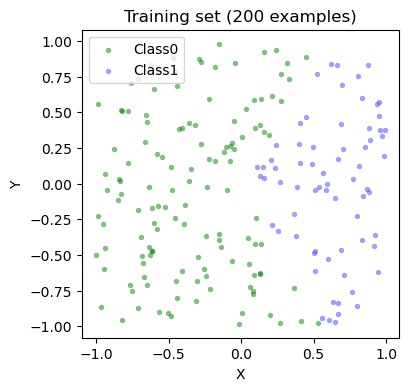

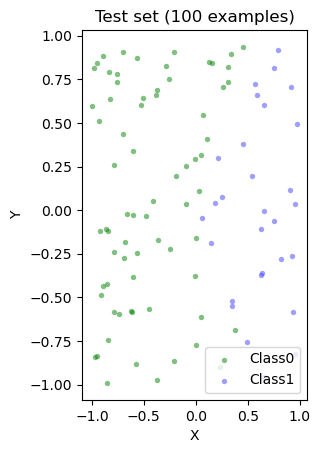

In [16]:
colors = np.array([[0, 0.5, 0], [0.25, 0.25, 1]])
helpers.plot_knn_training_test(data_train, data_test, labels_train, labels_test, colors, class_names)

## 5.2. The $k$-Nearest Neighbors Classifier

### 5.2.1 Distance metrics

In this exercise, we ask you to implement both Euclidean distance and Cosine similarity distance. 

#### Euclidean distance:

Refer to the exercise session on KNNs.


#### Cosine similarity:

Cosine similarity is a measure of similarity between two non-zero vectors.

From elementary geometry, recall the definition of cosine of the angle between two vectors: 

$$
\text{cosine}(\mathbf{v}, \mathbf{w}) = \frac{ \sum_{i=1}^d  \mathbf{v}_i  \mathbf{w}_i }{\| \mathbf{v} \| \| \mathbf{w} \| }
$$

Then we can simply define our distance metric as

$$
d(\mathbf{v}, \mathbf{w}) = 1 - \text{cosine}(\mathbf{v}, \mathbf{w})
$$


Implement both distance metrics below.

In [26]:
# example is a vector and training examples a matrix
def euclidean_dist(example, training_examples):
    return np.sqrt(((training_examples - example) ** 2).sum(axis=1))

# example is a vector and training examples a matrix
def cosine_dist(example, training_examples):
    vnorm = np.sqrt(np.sum(example ** 2))
    wnorm = np.sqrt(np.sum(training_examples ** 2, axis=1))
    cosine = np.sum(example * training_examples, axis=1) / vnorm / wnorm
    return 1 - cosine

We provide code for finding k nearest neighbors below.

In [18]:
# Find the indices of the k shortest distances from a list of distances
def find_k_nearest_neighbors(k, distances):
    indices = np.argsort(distances)[:k]
    return indices

During the exercise sessions, we considered a setting in which, given a list of neighbor labels, the sample label was predicted as the most frequent one within them. 

Let $(x,y)$ denote a test sample and $(x_k,y_k)$ the set of its k-NN.

For a binary classification problem, the majority vote solution can be expressed as

$$
y = \text{round}\left( \frac{ \sum_{i=1}^k  y_i }{k} \right)
$$
(Note that this is not valid for the multiclass scenario)

In this exercise, we ask you to implement a more sophisticated prediction scheme, where the neighbors' labels are weighted by the inverse of their distance to the test sample, i.e. 

$$
y = \text{round}\left( \frac{ \sum_{i=1}^k \frac{1}{d(\mathbf{x},\mathbf{x_i})} y_i }{ \sum_{i=1}^k \frac{1}{d(\mathbf{x},\mathbf{x_i})}} \right)
$$


Implement this weighting scheme below

In [19]:
def predict_label(neighbor_labels, neighbor_distance):
    # Inverse neighbor distance
    inv_dist = 1 / neighbor_distance
    return np.around(np.sum(neighbor_labels.astype(float) * inv_dist) / np.sum(inv_dist))

### 5.4 Putting everything together

Now we combine the functions we have written above to predict the label of one test example. 

To quantify the performance of our model, we will use the same score metric we have used in the multi-class logistic regression part of this exercise session, `helpers.my_accuracy_func`.

Below, we adapted the function `kNN` from the exercise session to work with different distance metrics.

In [20]:
def kNN_one_example(unlabeled_example, training_features, training_labels, k, distance):
    
    assert distance in ["euclidean", "cosine"]
    if distance == "euclidean":
        distances = euclidean_dist(unlabeled_example, training_features)
    elif distance == "cosine":
        distances = cosine_dist(unlabeled_example, training_features)
    nn_indices = find_k_nearest_neighbors(k, distances)               # Find neighbors
    neighbor_labels = training_labels[nn_indices]
    neighbor_distances = distances[nn_indices]
    best_label = predict_label(neighbor_labels, neighbor_distances)    # Pick the most common
    
    return best_label
    
def kNN(unlabeled, training_features, training_labels, k, distance):
    return np.apply_along_axis(kNN_one_example, 1, unlabeled, training_features, training_labels, k, distance)

We then provide a function kNN that applies kNN_one_example to an arbitrary number of examples (as you had in the exercise session). Run the cell below to see your model's results using both metrics.

Distance type  euclidean , accuracy is 0.99
Distance type  cosine , accuracy is 1.0


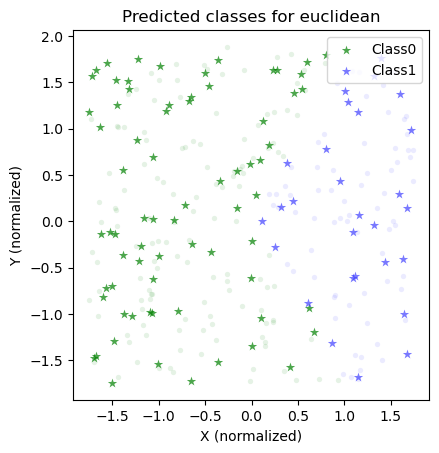

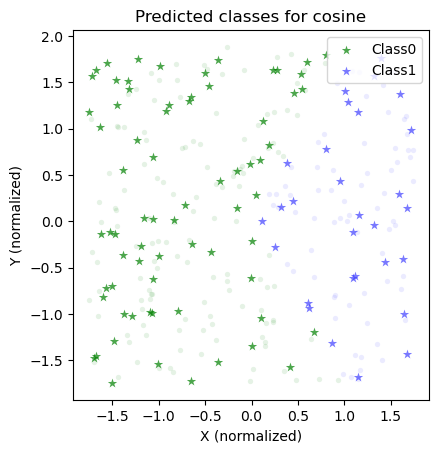

In [27]:
#process your data
#normalize your training data and your test data
mean_val = data_train.mean(axis=0,keepdims=True)
std_val = data_train.std(axis=0,keepdims=True)
norm_train_data = normalize(data_train,mean_val,std_val)[0]
norm_test_data = normalize(data_test,mean_val,std_val)[0]

#choose a k value
k = 20

# run KNN on your training and test data
for distance_type in ["euclidean",  "cosine"]:
    predicted_labels_test = kNN(norm_test_data, norm_train_data, labels_train, k, distance_type)
    accuracy = helpers.my_accuracy_func(predicted_labels_test, labels_test)
    print("Distance type ", distance_type, ", accuracy is", accuracy)
    
    # Visualize the predictions on the unannoated set
    plt.figure()
    plt.title("Predicted classes for " + distance_type)
    for i, class_name in enumerate(class_names):
        plt.scatter(*norm_train_data[labels_train==i].T,
                    c=colors[i, None], alpha=0.1, s=15, lw=0)
    for i, class_name in enumerate(class_names):    
        plt.scatter(*norm_test_data[predicted_labels_test==i].T,
                    c=colors[i, None], marker='*', alpha=0.7, s=50, lw=0, label=class_name)
    plt.gca().set_aspect('equal')
    plt.xlabel("X (normalized)")
    plt.ylabel("Y (normalized)")
    plt.legend();

**Q1. Which distance metric performs better, and why?** 

A) The cosine similarity, because the dataset does not contain enough samples

`correct` B) The cosine similarity, because of the spatial distribution of the data - cosine distance doesn't consider (care) about the magnitude but rather on the spatial arrangement of points (angle/orientation).

C) The Euclidean distance, because samples are linearly dependent 

D) The Euclidean distance, because we can always assume noise to be Gaussian


**Q2. What is the algorithmical complexity of your implementation of K-NN for a single test sample?Let N be the number of training samples and D the feature dimension**

`correct` A) $O(N\cdot log N)$ - the expensive computation in the K-NN implementation is sorting that can be performed in $O(N\cdot log N)$ in $\texttt{find\_k\_nearest\_neighbors}$.

B) $O(N^2)$

C) $O(D\cdot log N)$

D) $O(D\cdot N)$

**Q3. What are the parameters of your models?**

A) k

`correct` B) None - there is no training step, no parameters to be learned in KNN

C) N

D) D

**Q4. What are the hyper-parameters of your models?**

`correct` A) k - no. of neighbors considered for each data point, hyper-params affect the parameter and model behaviour while learning

B) None

C) N

D) D

# Part 6: Confusion Matrix 

A confusion matrix is a table that is often used to describe the performance of a classification model. It is a matrix of shape given by num_classes x num_classes. The rows of the confusion matrix represent the true labels while the columns represent the predicted labels.

For every data sample, we increment the value corresponding to the (row, col) position given by the true and predicted label.  

Hence, the diagonal elements represent the number of points for which the predicted label is equal to the true label, while the off-diagonal elements correspond to the samples that are mislabeled by the classifier. 

The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

Furthermore, one can also normalize the rows of the confusion matrix by the number of the samples of each class to obtain normalized confusion matrix 

In [28]:
"""
Implement Confusion matrix to visualize the performance of model

Input:
    true_labels : array of  ground truth labels of the dataset
    pred_label: array of predicted labels by the model for the given dataset
    num_classes: number of classes present in the data
    
    
output:
    cm: confusion matrix of shape (no of classes x no of classes)
    cm_normed: normalized confusion matrix of shape ( no of classes x no of classes)
"""

def confusion_matrix(true_labels, pred_labels, num_classes):
    # Initialize the confusion matrix
    cm = np.zeros((num_classes, num_classes), dtype=np.int32)

    for point in range(len(true_labels)):
        cm[true_labels[point]][pred_labels[point]] += 1

    cm_normed = cm.astype('float') / cm.sum(axis=1)[:, np. newaxis]

    print("Confusion matrix:\n {} \n\nNormalized confusion matrix:\n{}"
            .format(cm, cm_normed))

    return cm, cm_normed